# Detección de preferencias e impacto de factores externos 

Zuber es una nueva empresa de viajes compartidos que se está lanzando en Chicago. Nuestra tarea es encontrar patrones en la información disponible. Queremos comprender las preferencias de los pasajeros y el impacto de los factores externos en los viajes.

Además, analizaremos los datos de los competidores y probaremos la siguiente hipótesis:

- La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos.

Lo primero que realizamos para obtener los datos fue analizar los datos sobre el clima en Chicago en noviembre 2017 desde el siguiente sitio web: https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html

Obtuvimos los datos utilizando la librería **BeautifullSoup**. Luego con **SQL** realizamos un análisis exploratorio de datos para encontrar el número de viajes en taxi para cada empresa de taxis del 15 al 16 de noviembre 2017. Nombramos el campo resultante *trips_amount* y lo mostramos junto con el campo *company_name*.

Encontramos la cantidad de viajes para cada empresa de taxis cuyo nombre contenía las palabras "Yellow" o "Blue" del 1 al 7 de noviembre de 2017. Nombramos la variable resultante *trips_amount*. Agrupamos los resultados por el campo *company_name*. El archivo resultante no será utilizado en este notebook.

Descubrimos que en noviembre de 2017 las empresas de taxis más populares fueron **Flash Cab** y **Taxi Affiliation Services**. Encuentramos el número de viajes de estas dos empresas y asignamos a la variable resultante el nombre *trips_amount*. Juntamos los viajes de todas las demás empresas en el grupo *"Other"*. Agrupamos los datos por nombres de empresas de taxis y nombramos el campo con nombres de empresas de taxis *company*.

Un tercer paso, fue probar la hipótesis de que la duración de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos. Para ello, siempre con **SQL**, recuperamos los identificadores de los barrios *O'Hare* y *Loop* de la tabla *neighborhoods*. Para cada hora recuperamos los registros de condiciones meteorológicas de la tabla *weather_records*. Dividimos todas las horas en dos grupos: "Bad" si el campo description contiene las palabras "rain" o "storm" y "Good" para los demás. Nombramos el campo resultante *weather_conditions*. La tabla final incluye dos campos: fecha y hora (ts) y weather_conditions. 

Recuperamos de la tabla *trips* todos los viajes que comenzaron en el Loop (*neighborhood_id*: 50) y finalizaron en O'Hare (*neighborhood_id*: 63) un sábado. Obtuvimos las condiciones climáticas para cada viaje. Recuperamos también la duración de cada viaje ignorando los viajes para los que no hay datos disponibles sobre las condiciones climáticas.

Comenzaremos entonces nuestro análisis de los datos obtenidos.

# Contenido <a id='back'></a>

* [1 Inicialización](#inicio)
    * [1.1 Cargar datos](#carga_datos)
    * [1.2 Explorar datos iniciales](#explorar_datos)
        * [1.2.1 Tabla company_trips](#vexplorar_datos_company)
        * [1.2.2 Tabla dropoff](#explorar_datos_dropoff)
        * [1.2.3 Tabla trips_to_airport](#explorar_datos_airport)
* [2 Analisis de datos](#analisis_datos)
    * [2.1 Los 10 barrios principales](#analisis_datos_barrios)
    * [2.2 Cantidad de viajes por compañía](#analisis_datos_company)
* [3 Comprobación de Hipotesis](#hipotesis)
* [4 Conclusión General](#conclusion)


## Inicialización <a id='inicio'></a>

Con el fin de resolver nuestras dudas cargaremos las siguientes librerías:
- Pandas
- Matplotlib
- numpy
- scipy.stats

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

### Cargas de datos: <a id='carga_datos'></a>

Recibimos los siguientes archivos que cargaremos a continuación:
- project_sql_result_01.csv
- project_sql_result_04.csv
- project_sql_result_07.csv

In [45]:
company_trips = pd.read_csv('/datasets/project_sql_result_01.csv')

In [46]:
dropoff = pd.read_csv('/datasets/project_sql_result_04.csv')

In [47]:
trips_to_airport = pd.read_csv('/datasets/project_sql_result_07.csv')

### Explorar datos iniciales <a id='explorar_datos'></a>

#### Tabla company_trips <a id='explorar_datos_company'></a>

La tabla company_trips contiene los siguientes datos:
- company_name: nombre de la empresa de taxis
- trips_amount: el número de viajes de cada compañía de taxis el 15 y 16 de noviembre de 2017

In [48]:
print('Presentación de las columnas de company_trips:')
print(company_trips.columns)
print()
print('Revisión del número de líneas de company_trips:')
print(len(company_trips), 'líneas.')

Presentación de las columnas de company_trips:
Index(['company_name', 'trips_amount'], dtype='object')

Revisión del número de líneas de company_trips:
64 líneas.


In [49]:
company_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [50]:
company_trips.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


La tabla company_trips consta de 2 columnas (company_name y trips_amount) y 64 líneas. Los nombres de las columnas son adecuados, no hay valores ausentes y los tipos de datos están correctos.

#### Tabla dropoff <a id='explorar_datos_dropoff'></a>

La tabla dropoff contiene los siguientes datos:
- dropoff_location_name: barrios de Chicago donde finalizaron los viajes
- average_trips: el promedio de viajes que terminaron en cada barrio en noviembre de 2017

In [51]:
print('Presentación de las columnas de dropoff:')
print(dropoff.columns)
print()
print('Revisión del número de líneas de dropoff:')
print(len(dropoff), 'líneas.')

Presentación de las columnas de dropoff:
Index(['dropoff_location_name', 'average_trips'], dtype='object')

Revisión del número de líneas de dropoff:
94 líneas.


In [52]:
dropoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [53]:
dropoff.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


La tabla dropoff también consta de 2 columnas (dropoff_location_name y average_trips) y 94 líneas. Los nombres de las columnas son correctos, no hay valores ausentes y los tipos de datos son correctos, sin embargo pasaremos los promedios a valores enteros para facilitar su lectura.

**Convertir la columna average_trips al tipo correcto:**

In [54]:
dropoff['average_trips'] = dropoff['average_trips'].astype('int')
dropoff.head()

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546


#### Tabla trips_to_airport <a id='explorar_datos_airport'></a>

La tabla trips_to_airport contiene los siguientes datos:
- start_ts: fecha y hora de recogida
- weather_conditions: condiciones climáticas en el momento en el que comenzó el viaje
- duration_seconds: duración del viaje en segundos 

In [55]:
print('Presentación de las columnas de trips_to_airport:')
print(trips_to_airport.columns)
print()
print('Revisión del número de líneas de trips_to_airport:')
print(len(trips_to_airport), 'líneas.')

Presentación de las columnas de trips_to_airport:
Index(['start_ts', 'weather_conditions', 'duration_seconds'], dtype='object')

Revisión del número de líneas de trips_to_airport:
1068 líneas.


In [56]:
trips_to_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [57]:
trips_to_airport.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


La tabla trips_to_airport consta de 3 columnas (start_ts, weather_conditions y duration_seconds) y 1068 líneas. Los nombres de las columnas son correctos y no hay valores ausentes. Los tipos de datos deben ser cambiados para la columna star_ts para hacerlos del tipo DateTime, el resto está correcto.

**Convertir la columna start_ts al tipo correcto:**

In [58]:
trips_to_airport['start_ts'] = pd.to_datetime(trips_to_airport['start_ts'], format='%Y-%m-%d %H:%M:%S')
trips_to_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


## Analisis de datos <a id='analisis_datos'></a>

En este apartado identificaremos los 10 principales barrios en términos de finalización del recorrido. Luego revisaremos el comportamiento de las empresas de taxis con respecto al número de viajes y los 10 barrios principales por número de finalizaciones. En base a estos datos sacaremos conclusiones basadas en lo descubierto.

### Los 10 barrios principales <a id='analisis_datos_barrios'></a>

In [59]:
top_dropoff = dropoff.sort_values(by='average_trips', ascending=False).head(10)
print(top_dropoff)

  dropoff_location_name  average_trips
0                  Loop          10727
1           River North           9523
2         Streeterville           6664
3             West Loop           5163
4                O'Hare           2546
5             Lake View           2420
6            Grant Park           2068
7         Museum Campus           1510
8            Gold Coast           1364
9    Sheffield & DePaul           1259


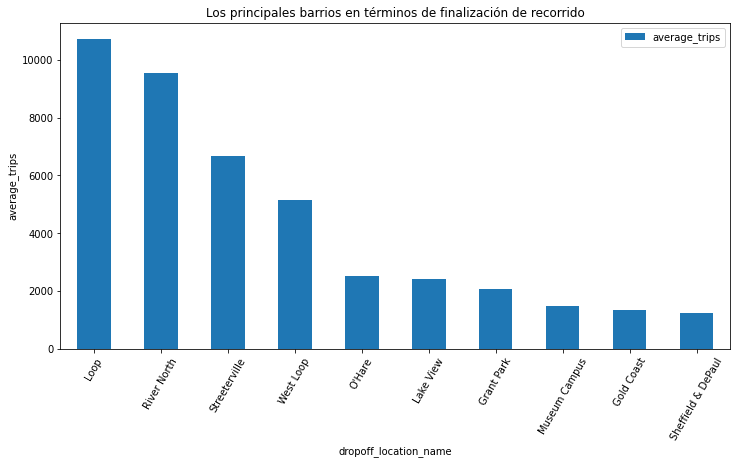

In [60]:
top_dropoff.plot(x='dropoff_location_name', kind='bar', figsize=(12,6))
plt.xlabel('dropoff_location_name')
plt.xticks(rotation=60)
plt.ylabel('average_trips')
plt.title('Los principales barrios en términos de finalización de recorrido')
plt.show(block=False)

### Cantidad de viajes por compañía <a id='analisis_datos_company'></a>

En esta sección analizaremos la cantidad de viajes por compañía. Para esto, revisaremos el gráfico siguiente:

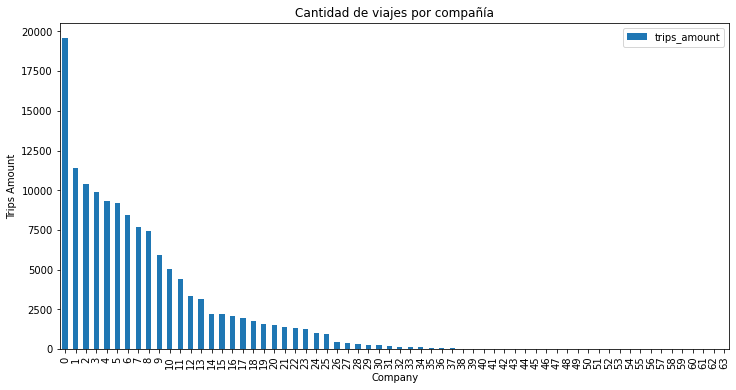

In [61]:
company_trips.plot(kind='bar', figsize=(12,6))
plt.xlabel('Company')
plt.ylabel('Trips Amount')
plt.title('Cantidad de viajes por compañía')
plt.show(block=False)

Como se puede ver, tenemos 63 compañías en la tabla, sin embargo, la mayoría de ellas a realizado mucho menos de 5000 viajes. Vamos a acotar nuestra tabla a solo las compañías que hicieron más de 5000 viajes:

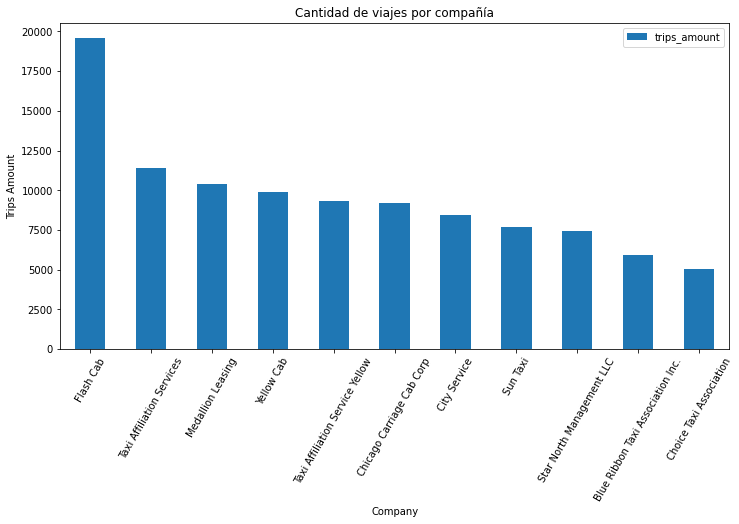

In [62]:
company_trips.query('trips_amount > 5000').plot(x='company_name', kind='bar', figsize=(12,6))
plt.xlabel('Company')
plt.xticks(rotation=60)
plt.ylabel('Trips Amount')
plt.title('Cantidad de viajes por compañía')
plt.show(block=False)

Como se puede apreciar, Flash Cab es la compañía que hizo más viajes con diferencia (casi 20000). Le sigue Taxi Affiliation Services con un poco más de 10000. En total tenemos solo 11 compañías que tienen más de 5000 viajes, y la mayoría de estas hicieron entre 7500 y 10000 viajes. 

## Comprobación de Hipótesis:<a id='hipotesis'></a>

A continuación nos concentraremos en estudiar nuestra hipótesis inicial:

"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos". Para ello generaremos las dos sentencias siguientes:

H0: La duración promedio de los viajes no cambia en los sábados lluviosos

Ha: La duración promedio cambia

Para nuestro estudio tomaremos un umbral de significancia de 5%. Este umbral del 5 % (2.5 % en cada lado) es una medida común de significancia estadística.

In [63]:
significance = 0.05

Antes de realizar la comprobación en si. Revisaremos si la varianza es la misma para el buen clima y el mal clima:

In [68]:
bad_weather_var = trips_to_airport.loc[trips_to_airport["weather_conditions"] == 'Bad', "duration_seconds"].var()
good_weather_var = trips_to_airport.loc[trips_to_airport["weather_conditions"] == 'Good', "duration_seconds"].var()
print('La varianza cuando el clima es malo es de:', bad_weather_var)
print('La varianza cuando el clima es buenos es de:', good_weather_var)

La varianza cuando el clima es malo es de: 520294.086002483
La varianza cuando el clima es buenos es de: 576382.009689509


Como se puede apreciar, la varianza para ambos climas es distinta.

In [70]:
stat, p_value = ttest_ind(
    trips_to_airport.loc[trips_to_airport["weather_conditions"] == 'Bad', "duration_seconds"],
    trips_to_airport.loc[trips_to_airport["weather_conditions"] == 'Good', "duration_seconds"],
    equal_var = False
)
print(f"""
    La duración promedio de los viajes en días lluviosos es de: {trips_to_airport.loc[trips_to_airport["weather_conditions"] == 'Bad', "duration_seconds"].mean()}
    La duración promedio de los viajes en días soleados es de: {trips_to_airport.loc[trips_to_airport["weather_conditions"] == 'Good', "duration_seconds"].mean()}

    t-statistic: {stat}
    p-value: {p_value}
""")

if p_value < significance:
    print('Rechazamos nuestra hipótesis nula')
else:
    print('No rechazamos nuestra hipótesis nula')


    La duración promedio de los viajes en días lluviosos es de: 2427.2055555555557
    La duración promedio de los viajes en días soleados es de: 1999.6756756756756

    t-statistic: 7.186034288068629
    p-value: 6.738994326108734e-12

Rechazamos nuestra hipótesis nula


## Conclusión General:<a id='conclusion'></a>

Para este estudio recibimos tres tablas.
La tabla **company_trips** que consta de 2 columnas (*company_name* y *trips_amount*) y 64 líneas.La tabla **dropoff** que también consta de 2 columnas (dropoff_location_name y average_trips) y 94 líneas. Ambas tablas venían sin valores ausentes y los datos correctamente presentados. Pasamos los datos de *average_trips* a valores enteros para simplificar la lectura de los mismos. Finalmente, la tabla **trips_to_airport** que consta de 3 columnas (start_ts, weather_conditions y duration_seconds) y 1068 líneas. Para esta tabla los nombres de las columnas son correctos y no hay valores ausentes. Pero tuvimos que cambiar los tipos de datos de la columna *star_ts* para hacerlos del tipo DateTime.

De las tablas pudimos rescatar las siguientes conclusiones: 
Los diez barrios principales en términos de finalización del recorrido corresponden a:
- Loop
- River North
- Streeterville
- West Loop
- O'Hare
- Lake View
- Grant Park
- Museum Campus
- Gold Coast
- Sheffield & DePaul
Ordenamos los nombres de mayor a menor número de viajes.

Con respecto a las empresas de taxis, tenemos un universo de 63 compañías en la tabla, sin embargo, la mayoría de ellas a realizado mucho menos de 5000 viajes en los días estudiados (el 15 y 16 de noviembre de 2017). **Flash Cab** es la compañía que hizo más viajes (casi 20000). Le sigue **Taxi Affiliation Services** con un poco más de 10000. En total tenemos solo 11 compañías que tienen más de 5000 viajes, y la mayoría de estas hicieron entre 7500 y 10000 viajes.

Finalmente, revisamos nuestra hipótesis:
"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos". Con el fin de comprobar esta hipotesis, creamos la hipótesis nula siguiente: *La duración promedio de los viajes no cambia en los sábados lluviosos*, pero de acuerdo a nuestro estudio rechazamos nuestra hipotesis nula.